In [33]:
import numpy as np
import pandas as pd
from tqdm import tnrange

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

In [7]:
tra_data=pd.read_csv("train.csv")
tst_data=pd.read_csv("test.csv")
tst_data.head()

,Webpage_id,Domain,Url
0,31,isrctn.com,http://www.isrctn.com/ISRCTN57801413
1,32,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
2,33,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
3,34,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...
4,35,www.clinicaltrialsregister.eu,https://www.clinicaltrialsregister.eu/ctr-sear...


In [17]:
tra_data.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfider...,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipp...,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exe...,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-bi...,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-...,news


In [60]:
tra_data.Tag.value_counts()

others            17417
news               7992
publication        7705
profile            5196
conferences        4666
forum              4503
clinicalTrials     2839
thesis             1800
guidelines         1329
Name: Tag, dtype: int64

In [6]:
size=tra_data.shape[0]+tst_data.shape[0]

In [119]:
%%writefile util.py
import re
from bs4 import BeautifulSoup

r=re.compile('<p.+/p>')
r2=re.compile('>(.*?)<')
sep='!@#$%^&*()'

def write_pages_text(k,beg,end):
    with open('pages%d.txt'%k,'w',encoding='utf-8') as w:
        for i in range(beg,end):
            with open('pages/%d.html'%(i+1),encoding='utf-8') as o:
                p='.'.join([t.strip() for t in BeautifulSoup(o).get_text(sep).split(sep) if t.find('{')==-1 and len(t.strip())>0])
    #             print(p)
                w.write(p.replace('\n','')+'\n')
            


Overwriting util.py


In [7]:
# import multiprocessing
# from util import write_pages_text

# procs=4
# rng=size//procs
# for i in range(procs):
#     if i < procs-1:
#         p=multiprocessing.Process(target=write_pages_text, args=(i+1,i*rng,(i+1)*rng))
#     else:
#         p=multiprocessing.Process(target=write_pages_text, args=(i+1,i*rng,size))
#     p.start()
# ! cat pages1.txt pages2.txt pages3.txt pages4.txt > pages.txt

In [25]:
def load_words():
    with open('words_alpha.txt') as word_file:
        valid_words = set(word_file.read().split())

    return valid_words
words_dict=load_words()
len(words_dict)

370099

In [29]:
with open('pages.txt',encoding='utf-8') as o:
    lines=o.readlines()
    table=str.maketrans('','','!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~')
    for i in tnrange(len(lines)):
        l = lines[i]
        words = [w.translate(table).lower() for w in l.split() if w.translate(table).lower() in words_dict]
        lines[i]=' '.join(words)
    pages=[lines[i-1] for i in tra_data.Webpage_id]
    pages_tst=[lines[i-1] for i in tst_data.Webpage_id]
    

53447 9 5938 466.0 114.0


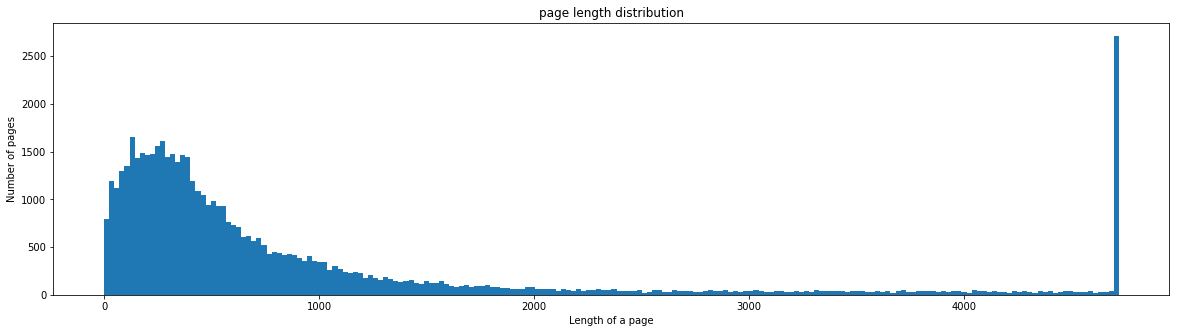

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
pages_n=tra_data.shape[0]
classes_n=tra_data.Tag.nunique()
pages_per_cls=pages_n//classes_n

def get_num_words_per_page(page_texts):
    """Returns the median number of words per page given corpus.

    # Arguments
        page_texts: list, page texts.

    # Returns
        int, median number of words per page.
    """
    num_words = [len(s.split()) for s in page_texts]
    return np.median(num_words)

def plot_page_length_distribution(page_texts):
    """Plots the page length distribution.

    # Arguments
        pages_texts: list, page texts.
    """
    lens=[len(s.split()) for s in page_texts]
    l,u=np.percentile(lens,[0,95])
    plt.hist(np.clip(lens,l,u), 200)
    plt.xlabel('Length of a page')
    plt.ylabel('Number of pages')
    plt.title('page length distribution')
    plt.show()
    
words_per_page=get_num_words_per_page(pages)

print(pages_n,classes_n,pages_per_cls,words_per_page,pages_n//words_per_page)
plot_page_length_distribution(pages)

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts, tst_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    
    x_tst = vectorizer.transform(tst_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    x_tst = selector.transform(x_tst).astype('float32')
    return x_train, x_val, x_tst

label_coder=LabelEncoder()
tra_data['label']=label_coder.fit_transform(tra_data.Tag)

pages_tra,pages_val,y_tra,y_val=train_test_split(pages,tra_data.label,test_size=0.1)

x_tra_ngram,x_val_ngram,x_tst_ngram=ngram_vectorize(pages_tra,y_tra,pages_val,pages_tst)

C:\apps\Anaconda2\envs\py3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\apps\Anaconda2\envs\py3\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [45]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [71]:


def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.4):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    x_train, train_labels, x_val, val_labels = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = train_labels.nunique()
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
#     x_train, x_val = ngram_vectorize(
#         train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)
    model.summary()

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    h = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = h.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    return model

word_bag_mlp=train_ngram_model((x_tra_ngram,y_tra,x_val_ngram,y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_24 (Dropout)         (None, 20000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                1280064   
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 585       
Total params: 1,280,649
Trainable params: 1,280,649
Non-trainable params: 0
_________________________________________________________________
Train on 48102 samples, validate on 5345 samples
Epoch 1/1000
 - 22s - loss: 1.3459 - acc: 0.5920 - val_loss: 0.9978 - val_acc: 0.6939
Epoch 2/1000
 - 21s - loss: 0.9573 - acc: 0.7055 - val_loss: 0.8654 - val_acc: 0.7285
Epoch 3/1000
 - 21s - loss: 0.8461 - acc: 0

In [59]:
def submit(model,x_tst,name):
    y_pred=model.predict_classes(x_tst)
    results=tst_data[['Webpage_id']].copy()
    results['Tag']=[label_coder.classes_[c] for c in y_pred]

    results.to_csv('%s.csv'%name,index=False)
    return results

In [72]:
results=submit(word_bag_mlp,x_tst_ngram,'word_bag_mlp_drop04')
results.Tag.value_counts()

others            9660
publication       4282
news              3710
profile           2259
conferences       2202
forum             2138
clinicalTrials     801
thesis             437
guidelines         298
Name: Tag, dtype: int64

In [61]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text


# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts, tst_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)
    x_tst = tokenizer.texts_to_sequences(tst_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    x_tst = sequence.pad_sequences(x_tst, maxlen=max_length)
    return x_train, x_val, x_tst, tokenizer.word_index

x_tra_seq,x_val_seq,x_tst_seq,word_index=sequence_vectorize(pages_tra,pages_val,pages_tst)
len(word_index)

84278

In [66]:
def loadGloveModel(gloveFile):
    f = open(gloveFile,'r',encoding='utf-8')
    model = {}
    for _ in tnrange(int(400000)):
        splitLine = f.readline().split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    return model

EMBEDDING_DIM=200
glove_model=loadGloveModel('glove.6B.%dd.txt'%EMBEDDING_DIM)

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [68]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D



def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

def train_cnn_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=16,
                      dropout_rate=0.2):

    x_train, train_labels, x_val, val_labels = data
    num_classes = train_labels.nunique()
    
    # Create model instance.
    model = sepcnn_model(2,128,3,EMBEDDING_DIM,0.2,2,(x_train.shape[1],),num_classes,len(word_index)+1,True,False,embedding_matrix)
    model.summary()
    
    

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    h = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = h.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))


seq_cnn_model=train_cnn_model((x_tra_seq,y_tra,x_val_seq,y_val),)
submit(seq_cnn_model,x_tst_seq,'seq_cnn_model')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 200)          16855800  
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d_29 (Separab (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_30 (Separab (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 250, 128)          0         
_________________________________________________________________
separable_conv1d_31 (Separab (None, 250, 256)          33408     
_________________________________________________________________
separable_conv1d_32 (Separab (None, 250, 256)          66560     
__________

KeyboardInterrupt: 